In [6]:
import pandas as pd
from src.data import *
from src.portfolio import *
from src.efficient_frontier import *
from src.plot import *
import yfinance as yf
from scipy.optimize import Bounds, LinearConstraint
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import risk_matrix

In [7]:
risk_matrix(haha)

,ABB.ST,ADDT-B.ST,ALFA.ST,ATRLJ-B.ST,AXFO.ST,AZA.ST,AZN.ST,BALD-B.ST,BILL.ST,BINV.ST
ABB.ST,2.116272,0.615712,0.984164,0.622889,0.199210,0.875874,0.246075,1.003563,0.471997,0.741142
ADDT-B.ST,0.615712,1.861347,0.805397,0.462360,0.244742,0.784629,-0.031658,0.490772,1.031758,0.979650
ALFA.ST,0.984164,0.805397,1.807596,0.754892,0.340601,0.931566,0.062935,0.667184,0.886481,0.459933
ATRLJ-B.ST,0.622889,0.462360,0.754892,2.603358,0.159656,0.449740,-0.075183,0.935935,0.739786,0.326760
AXFO.ST,0.199210,0.244742,0.340601,0.159656,0.993788,0.285917,-0.117403,0.196090,0.468657,0.027168
AZA.ST,0.875874,0.784629,0.931566,0.449740,0.285917,2.620920,-0.044819,1.077824,1.039901,1.139674
AZN.ST,0.246075,-0.031658,0.062935,-0.075183,-0.117403,-0.044819,0.753162,0.158074,0.124694,-0.275645
BALD-B.ST,1.003563,0.490772,0.667184,0.935935,0.196090,1.077824,0.158074,5.140420,1.186333,1.506362
BILL.ST,0.471997,1.031758,0.886481,0.739786,0.468657,1.039901,0.124694,1.186333,5.417275,0.613884
BINV.ST,0.741142,0.979650,0.459933,0.326760,0.027168,1.139674,-0.275645,1.506362,0.613884,6.100158


In [5]:
haha = prices.iloc[:120,:]
mean_historical_return(haha, compounding = True, frequency=12)

                ABB.ST  ADDT-B.ST     ALFA.ST  ATRLJ-B.ST    AXFO.ST  \
Date                                                                   
2003-01-01   19.849524   2.070652   14.625000   20.500000  39.750000   
2003-02-01   14.291657   2.147343   17.875000   20.250000  40.250000   
2003-03-01   15.800221   1.993961   17.250000   20.000000  40.375000   
2003-04-01   19.928923   2.224034   20.000000   19.750000  38.250000   
2003-05-01   18.976145   2.645833   20.000000   19.625000  39.125000   
...                ...        ...         ...         ...        ...   
2012-08-01  115.500000  13.881040  113.400002   79.800003  58.500000   
2012-09-01  123.699997  13.689313  119.099998   84.500000  61.724998   
2012-10-01  119.800003  12.692332  115.199997   87.250000  61.400002   
2012-11-01  130.000000  13.804350  130.800003   87.500000  61.599998   
2012-12-01  134.100006  14.264495  135.300003   87.000000  61.250000   

               AZA.ST      AZN.ST  BALD-B.ST    BILL.ST     BIN

ABB.ST        0.212453
ADDT-B.ST     0.214840
ALFA.ST       0.251504
ATRLJ-B.ST    0.156922
AXFO.ST       0.044563
AZA.ST        0.257091
AZN.ST        0.004866
BALD-B.ST     0.081398
BILL.ST       0.014252
BINV.ST      -0.119642
dtype: float64

In [2]:
esg_data = esg_score_weight(pd.read_excel('data/ESG_DATA.xlsx'), np.array([1/3,1/3,1/3]))
full_data = stock_monthly_close(esg_data, dates=('2003-01-01','2023-01-01'))
prices, esg = seperate_full_data(full_data)
prices = filter_prices(prices, 0, 10)


1 Failed download:
- JOBS.ST: No data found for this date range, symbol may be delisted

1 Failed download:
- PFE.ST: Exception('Lost data during merge despite all attempts to align data (see above)')

1 Failed download:
- MSEIS.OL: No timezone found, symbol may be delisted

1 Failed download:
- JYSK.CO: Exception('Lost data during merge despite all attempts to align data (see above)')


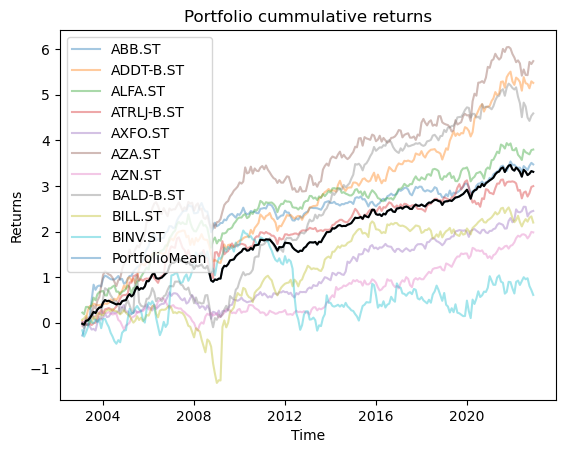

In [3]:
plot_cummulative_portfolio_returns(prices)

In [4]:
estimate_rolling_window(prices)

,ABB.ST,ADDT-B.ST,ALFA.ST,ATRLJ-B.ST,AXFO.ST,AZA.ST,AZN.ST,BALD-B.ST,BILL.ST,BINV.ST
2013-01-01,0.210509,0.212872,0.249166,0.155518,0.044184,0.254696,0.004825,0.080693,0.014132,-0.118706
2014-01-01,0.148698,0.232909,0.195689,0.134676,0.064328,0.195319,0.007196,0.098339,0.029222,-0.114200
2015-01-01,0.157581,0.194279,0.181404,0.121314,0.094269,0.192405,0.076174,0.181305,0.058421,-0.104233
2016-01-01,0.063572,0.173266,0.142233,0.104446,0.109359,0.139290,0.045758,0.312569,0.104175,-0.105934
2017-01-01,0.045641,0.122706,0.063468,0.044580,0.081773,0.120055,0.025220,0.268997,0.087414,-0.139809
2018-01-01,0.034455,0.172412,0.086389,0.082453,0.101051,0.118785,0.079724,0.345886,0.154828,-0.188602
2019-01-01,0.047785,0.207900,0.124332,0.092070,0.143312,0.181372,0.078303,0.436183,0.270579,-0.183196
2020-01-01,0.052145,0.239384,0.088315,0.128445,0.145389,0.102679,0.106095,0.406567,0.104260,-0.247183
2021-01-01,0.041221,0.224526,0.051162,0.072271,0.126321,0.169934,0.102294,0.307377,0.109906,-0.220687
2022-01-01,0.093112,0.324116,0.100938,0.095111,0.154317,0.251658,0.125167,0.356487,0.135070,-0.185201


In [ ]:
calculate_efficient_frontier_esg()

In [ ]:
plot_efficient_frontier_return()

In [ ]:
parameters = []
for i in range(0, 11):
  sr_opt_set = set()
  print(f"-------------------------- 20{3+i:02d}-20{13+i:02d} --------------------------")


  # define the rolling window
  sample_rolling_window = price[i*12:i*12+(12*window_size)]

  ret_port = historical_return(sample_rolling_window, frequency=12)
  print(ret_port)

  ret_port2 = annual_return(sample_rolling_window[0], sample_rolling_window[-1], window_size)
  print(ret_port2)

In [ ]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier for rolling windows', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_sr_vol,  opt_sr_ret, marker='o', color = f'{colors[i]}', markersize=12)# label=f'20{3+i:02d}-20{13+i:02d} Min var') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=3, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0,1])
plt.ylim([frontier_y.min(),frontier_y.max()])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
portfolio_covariance(df)

In [ ]:
portfolio_mean(df)

In [ ]:
cov = portfolio_covariance(df)
portfolio_std(cov, w)

In [ ]:
portfolio_sharp_ratio(df, w, cov)

In [ ]:
#bounds = Bounds(-2, 5)

#Create x0, the first guess at the values of each asset's weight.
#w0 = np.linspace(start=1, stop=0, num=cov.shape[1])
#x0 = w0/np.sum(w0)
# All weights between 0 and 1
# # The second boundary is the sum of weights.
#linear_constraint = LinearConstraint(np.ones((cov.shape[1],), dtype=int),1,1)
#options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}
 

In [ ]:
def portfolio_minimize_risk(port_return, 
                                port_covariance, 
                                esg_data, 
                                x0,
                                linear_constraint, 
                                bounds, 
                                options = None):
    """
    Function that will take different inputs including esg score data and compute the minimum risk of different portfolios 
    :param: A dataframe of the portfolio covariance matrix
    :param: A dataframe of esg scores of the different assets in portfolio
    :param: x0 argument that is the initial guess for the minimizer
    :param: Linear constraints for the minimizer
    :param: Bounds for the minimizer
    :param: 
    :param: Options for the minimizer
    :returns: A dataframe containing portfolio weight choice for minimizing portfolio risk using esg scores
    """
    
    results = {'esg':[],
               'weights':[],
               'risk':[],
               'return':[]}
    
    function = lambda weight: portfolio_std(port_cov=port_covariance, weights=weight)
    constraint_esg = {'type': 'eq', 'fun': lambda weight: np.dot(weight, esg_data)}
    result = minimize(function, 
                      x0, 
                      method='trust-constr', 
                      bounds=bounds, 
                      constraints=[linear_constraint, constraint_esg], 
                      options=options)
   
    optimal_weights = list(result['x'])
    print(optimal_weights)
    optimal_esg = np.dot(optimal_weights, esg_data)
    results['esg'].append(optimal_esg)
    results['weights'].append(optimal_weights)
    results['risk'].append(result['fun'])
    results['return'].append(np.dot(optimal_weights, port_return.sum()))

    return results


In [ ]:
# set the window size
#window_size = 2

# make different lists to append data in every window
#expected_return = []
#expected_year = []

#def simple_return(beginning_price, end_price):
#  return ((end_price-beginning_price)/beginning_price)

#def annual_return(simple_return, years_held):
#  return (((simple_return+1)**(1/years_held))-1)

# setup af loop to iterate through window and make calculations
#for i in range(0, 6):

  # define the rolling window
#  sample_rolling_window = df[i*12:i*12+(12*window_size)]

  # calculate the expected return as a dataframe
#  window_monthly_returns = pd.DataFrame()
#  window_monthly_returns = sample_rolling_window
#  simple_window_yearly_returns_mean = simple_return(window_monthly_returns.iloc[0], window_monthly_returns.iloc[-1])
#  annual_window_return = annual_return(simple_window_yearly_returns_mean, window_size)

  # append the results of expected return and the years to list
#  expected_return.append(annual_window_return)

# make list of expected return into a dataframe
#for x in range(2013, 2024):
#  expected_year.append(dt(x,1,1))
  
#expected_return = pd.DataFrame(expected_return, index=expected_year)

#expected_return


In [ ]:
#esg_data = pd.read_excel('ESG_DATA.XLS')
#for index, row in esg_data.iterrows():
    # stockholm exchange
    if row['Isin'].startswith('SE'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    
    # swiss exchange
    elif row['Isin'].startswith('CH0242214887'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('CH1122548808'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('CH'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SW'
    
    # toroto exchange
    elif row['Isin'].startswith('CA98936C1068'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    elif row['Isin'].startswith('CA'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.TO'
    elif row['Isin'].startswith('GB'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    
    # paris exchange
    elif row['Isin'].startswith('FR'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.PA'

    # copenhagen exchange
    
    elif row['Isin'].startswith('DK0060668796'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('DK0060520450'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FI4000297767'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO' 
    elif row['Isin'].startswith('DK'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO'

    # oslo exchange
    elif row['Isin'].startswith('NO'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('KYG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL' 
    elif row['Isin'].startswith('CY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('BMG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('MHY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
    elif row['Isin'].startswith('US36467X2062'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('SGX'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FO0000000179'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'

    elif row['Isin'].startswith('MT0000580101'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.DE'
    elif row['Isin'].startswith('MT0001390104'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('MT'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
   